# New approach to GPs to improve performance

In [1]:
from scipy import stats, special, math
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pymc3 as pm
import arviz as az
import pandas as pd
from theano import shared
from theano import tensor as T
import seaborn as sns
from scipy.special import expit as logistic
import statsmodels as sm
from statsmodels.graphics import tsaplots as smplots
import warnings
import theano
import theano.tensor as tt
from scipy.special import expit as logistic
import seaborn as sns

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import statsmodels as stm

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
prison = pd.read_csv('./data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [128]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

# Forecast horizon
h = 8
y_train = prison_pivot.iloc[:-8,:]
y = prison_pivot

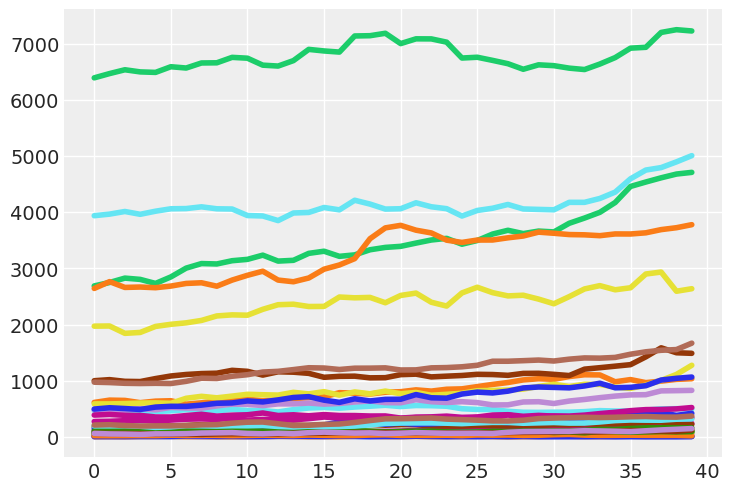

In [129]:
def generate_groups_info(y):
    
    n=y.shape[0]
    s=y.shape[1]
    n_series = y.columns.unique().shape[0]
    
    state_idx_list = pd.get_dummies(
        [i[0] for i in y]
    ).values.argmax(1)

    gender_idx_list = pd.get_dummies(
            [i[1] for i in y]
        ).values.argmax(1)

    legal_idx_list = pd.get_dummies(
            [i[2] for i in y]
        ).values.argmax(1)

    state = np.unique(state_idx_list).shape[0]
    gender = np.unique(gender_idx_list).shape[0]
    legal = np.unique(legal_idx_list).shape[0]
    
    state_idx = pd.get_dummies(
            [i[0] for i in y]
        ).values.argmax(1)
    state_idx = np.tile(state_idx, (n,1)).flatten('F')
    gender_idx = pd.get_dummies(
            [i[1] for i in y]
        ).values.argmax(1)
    gender_idx = np.tile(gender_idx, (n,1)).flatten('F')

    legal_idx = pd.get_dummies(
            [i[2] for i in y]
        ).values.argmax(1)
    legal_idx = np.tile(legal_idx, (n,1)).flatten('F')

    state = np.unique(state_idx).shape[0]
    gender = np.unique(gender_idx).shape[0]
    legal = np.unique(legal_idx).shape[0]

    n_series_idx = np.tile(np.arange(s), (n,1)).flatten('F')
    n_series_idx_list = np.arange(s)

    state_idx_list = pd.get_dummies(
            [i[0] for i in y]
        ).values.argmax(1)

    gender_idx_list = pd.get_dummies(
            [i[1] for i in y]
        ).values.argmax(1)

    legal_idx_list = pd.get_dummies(
            [i[2] for i in y]
        ).values.argmax(1)

    state = np.unique(state_idx_list).shape[0]
    gender = np.unique(gender_idx_list).shape[0]
    legal = np.unique(legal_idx_list).shape[0]
    
    state_names = []
    gender_names = []
    legal_names = []
    [state_names.append(i[0]) for i in y.columns]
    [gender_names.append(i[1]) for i in y.columns]
    [legal_names.append(i[2]) for i in y.columns]

    state_names = np.unique(state_names)
    gender_names = np.unique(gender_names)
    legal_names = np.unique(legal_names)

    return (state_idx, 
            gender_idx,
            legal_idx,
            n_series_idx,
            state,
            gender,
            legal,
            n,
            s,
            n_series,
            state_names,
            gender_names,
            legal_names
           )


states_names=[]
gender_names=[]
legal_names=[]

(state_idx, 
 gender_idx, 
 legal_idx,
 n_series_idx, 
 state, 
 gender,
 legal,
 n,
 s,
 n_series,
 state_names,
 gender_names,
 legal_names) = generate_groups_info(y_train)


y_train = y_train.values
y_ = y_train
X = np.arange(y_train.shape[0]).reshape(y_train.shape[0], 1)
plt.plot(X, y_train);

y_ = y_.T.ravel()

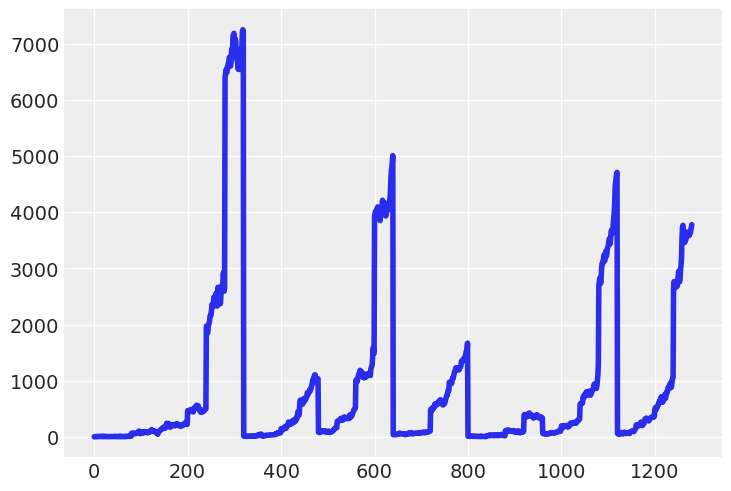

In [130]:
plt.plot(y_);

We will define a more compact covariance matrices to model latent behaviours of each element of each group. We only need them to be UxU where U is the unique number of inputs for the given GP. All the GPs will therefore have a covariance matrix that depend on number of time points and it would be txt, where t is the number of periods observed in the data. In our case it is 48. The Poisson likelihood needs to be computed for the N data points (all time series).

In [158]:
gp_dict = {}
f_dict = {}
f_flat = {}

with pm.Model() as model:
    
    # Hyper-parameter priors
    
    period = pm.Laplace('period', 4, 0.1)
  
    
    l_t_state = pm.Gamma('l_t_state', alpha=5, beta=1, shape = state)
    l_p_state = pm.Gamma('l_p_state', alpha=5, beta=1, shape = state)
    η_trend_state = pm.HalfNormal('η_trend_state', 5, shape = state)
    η_per_state = pm.HalfNormal('η_per_state',5, shape = state)
    σ_state  = pm.HalfNormal("σ_state",  sigma=0.1, shape = state)
    
    l_t_gender = pm.Gamma('l_t_gender', alpha=5, beta=1, shape = gender)
    l_p_gender = pm.Gamma('l_p_gender', alpha=5, beta=1, shape = gender)
    η_trend_gender = pm.HalfNormal('η_trend_gender', 5, shape = gender)
    η_per_gender = pm.HalfNormal('η_per_gender',5, shape = gender)
    σ_gender  = pm.HalfNormal("σ_gender",  sigma=0.1, shape = gender)
    
    l_t_legal = pm.Gamma('l_t_legal', alpha=5, beta=1, shape = legal)
    l_p_legal = pm.Gamma('l_p_legal', alpha=5, beta=1, shape = legal)
    η_trend_legal = pm.HalfNormal('η_trend_legal', 5, shape = legal)
    η_per_legal = pm.HalfNormal('η_per_legal',5, shape = legal)
    σ_legal  = pm.HalfNormal("σ_legal",  sigma=0.1, shape = legal)
    
    
    hy_a0_mu = pm.Normal('hy_a0_mu', mu=0.0, sd=10)
    
    a0 = pm.Normal('a0', mu=hy_a0_mu, sd=2, shape=n_series)      
    a_state = pm.Normal('a_state', mu=0, sd=2, shape=state)
    a_gender = pm.Normal('a_gender', mu=0, sd=2, shape=gender)
    a_legal = pm.Normal('a_legal', mu=0, sd=2, shape=legal)

    b_state = pm.Normal('b_state', mu=0, sd=0.5, shape=state)
    b_gender = pm.Normal('b_gender', mu=0, sd=0.5, shape=gender)
    b_legal = pm.Normal('b_legal', mu=0, sd=0.5, shape=legal)

       
    for idx, name in enumerate(state_names):
        
        # index varible that indicates where a specific GP is active
        # for instance, GP_fem is only active in fem time series
        idx_dict[name] = np.where(state_idx==idx,1,0)
        
        # mean function for the GP with specific parameters per group
        mu_func = pm.gp.mean.Linear(intercept = a_state[idx],
                             coeffs = b_state[idx])
        
        # cov function for the GP with specific parameters per group
        cov = (η_trend_state[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_state[idx])
                + η_per_state[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_state[idx]) 
                + pm.gp.cov.WhiteNoise(σ_state[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    for idx, name in enumerate(gender_names):
        
        idx_dict[name] = np.where(gender_idx==idx,1,0)
        
        mu_func = pm.gp.mean.Linear(intercept = a_gender[idx],
                             coeffs = b_gender[idx])
        
        cov = (η_trend_gender[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_gender[idx])
                + η_per_gender[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_gender[idx]) 
                + pm.gp.cov.WhiteNoise(σ_gender[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_%s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    for idx, name in enumerate(legal_names):
        
        idx_dict[name] = np.where(legal_idx==idx,1,0)
        
        mu_func = pm.gp.mean.Linear(intercept = a_legal[idx],
                             coeffs = b_legal[idx])
        
        cov = (η_trend_legal[idx]**2 * pm.gp.cov.Matern32(input_dim=1, ls=l_t_legal[idx])
                + η_per_legal[idx]**2 * pm.gp.cov.Periodic(1, period=period, ls=l_p_legal[idx]) 
                + pm.gp.cov.WhiteNoise(σ_legal[idx]))
        
        gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f_dict[name] = gp_dict[name].prior('f_ %s' % name, X=X, reparameterize=True)
        f_flat[name] = tt.tile(f_dict[name], (s,)) * idx_dict[name]
        
    
    # Sum of all the GPs designed per group
    f = sum(f_flat.values())
        
    
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f + a0[n_series_idx]), observed=y_)

In [159]:
with model:
    mp = pm.find_MAP()

In [154]:
mp_list = [{key: mp.get(key) for key in [i for i in mp if not any(j in i for j in ['log', 'f_rotated_', 'rotated'])]}]

In [155]:
mp_list

[{'period': array(3.999979),
  'hy_a0_mu': array(0.00091097),
  'a0': array([ 0.258984  , -0.47160589,  0.28614113, -0.13815263,  0.12745303,
         -0.04841776, -0.01361054,  0.0218192 , -0.00859525, -0.23748456,
          0.01498814,  0.21916695, -0.03088571,  0.19073872, -0.18577959,
          0.09159716,  0.31130289, -0.36510689,  0.19022872, -0.11246874,
         -0.04052829,  0.0877193 , -0.19634613,  0.12790565, -0.06385613,
          0.08866008, -0.22240132,  0.24525638, -0.02213085,  0.26082798,
         -0.34046943,  0.15065888]),
  'a_state': array([-0.06464129,  0.08723602, -0.01193262,  0.06566268,  0.02394808,
         -0.02125738,  0.04765111,  0.04887868]),
  'a_gender': array([0.03704304, 0.13850223]),
  'a_legal': array([0.06446304, 0.11108222]),
  'b_state': array([-0.01384532,  0.02305732,  0.00694754,  0.01876039,  0.01052196,
         -0.01862794,  0.02043154,  0.01962772]),
  'b_gender': array([0.02030103, 0.04657216]),
  'b_legal': array([0.02907002, 0.0378031

In [147]:
with model:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred], 
                                                  samples=500)

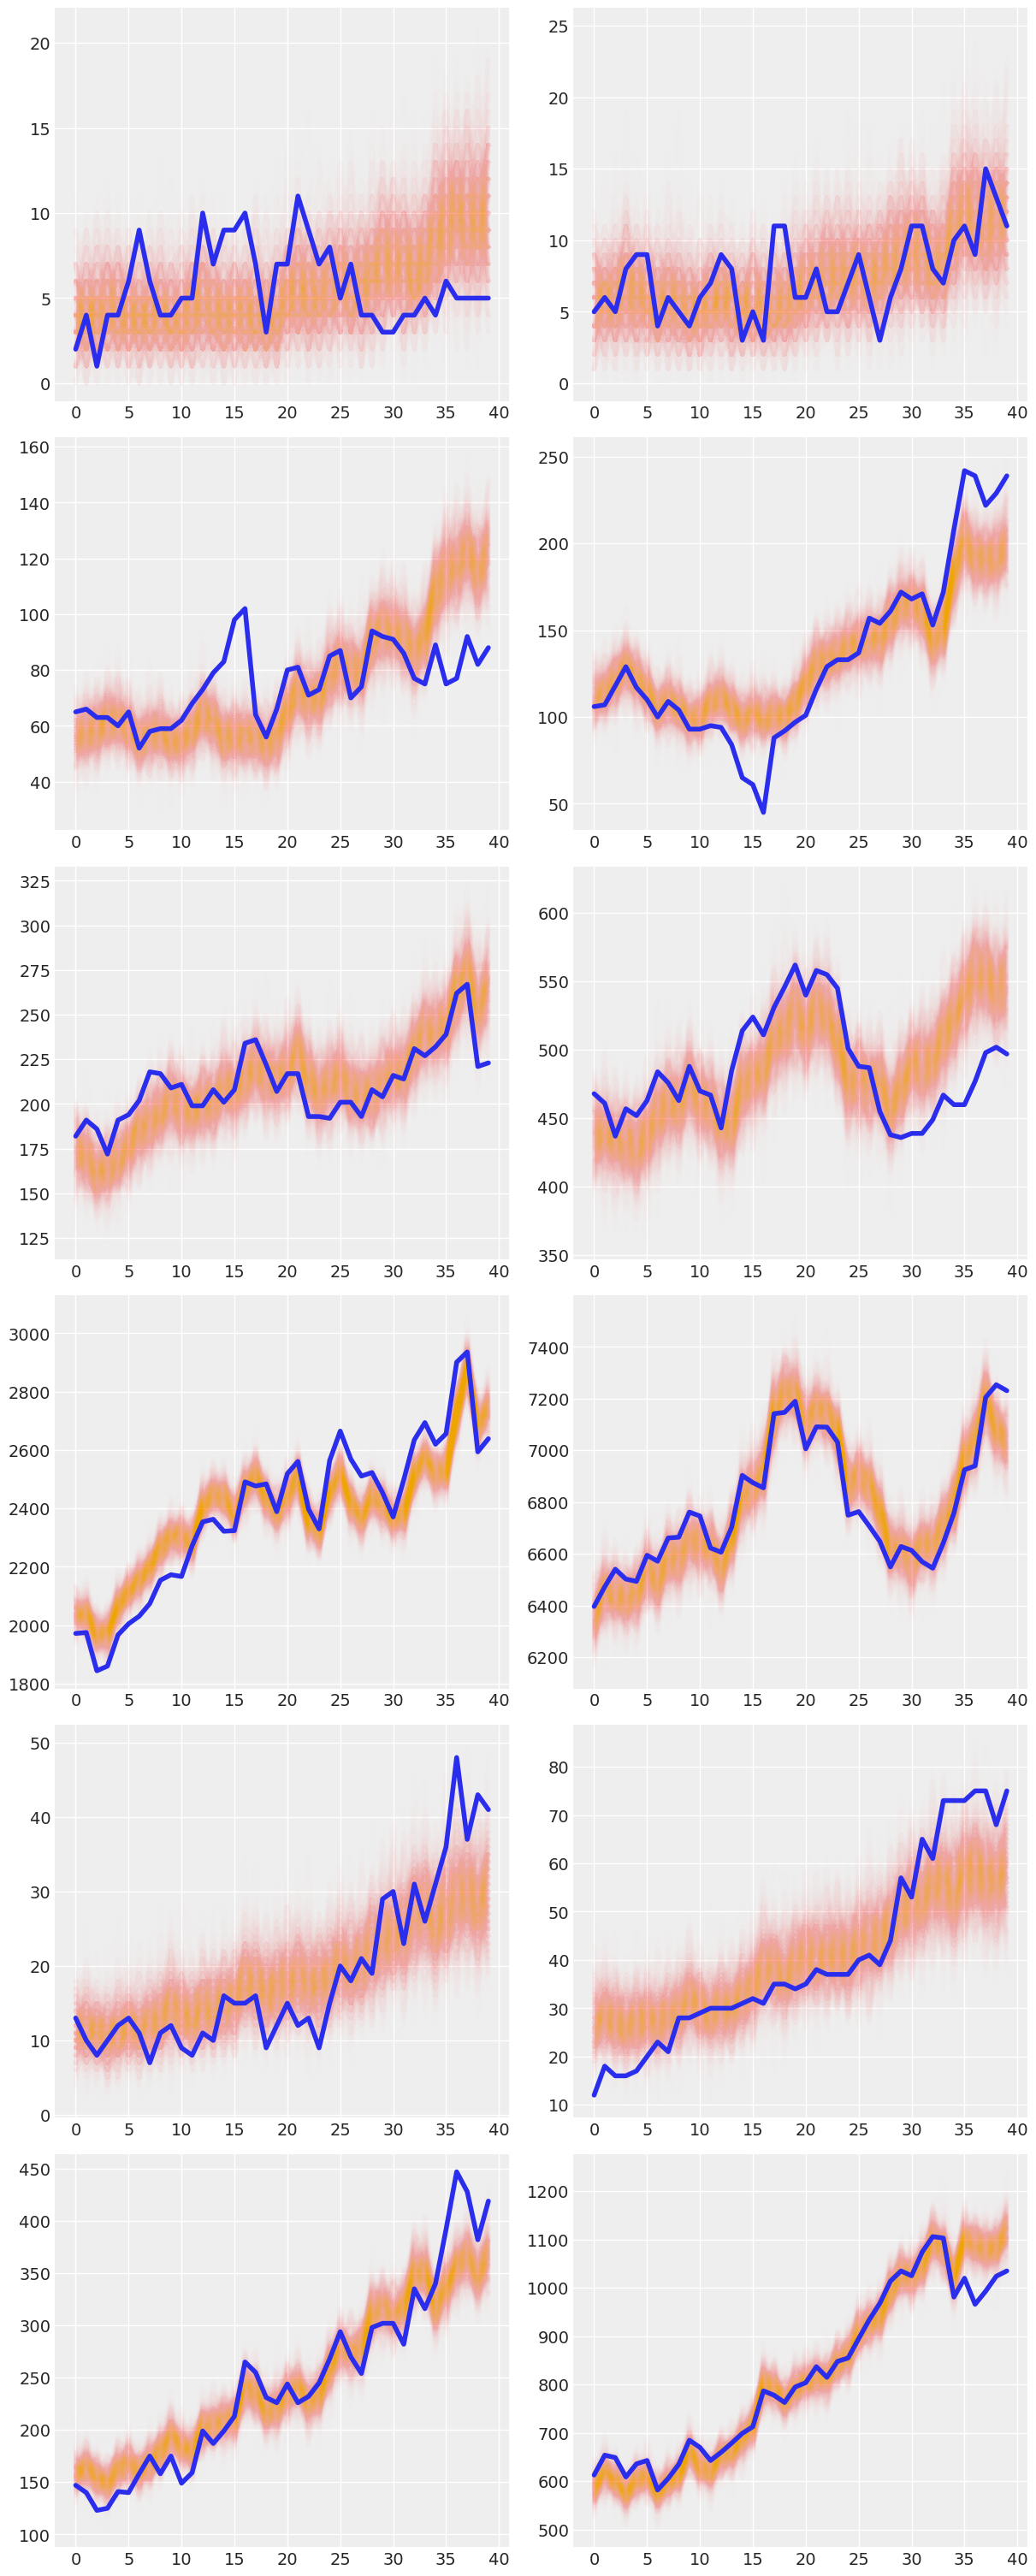

In [148]:
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)
for i in range(12):
    ax[i].plot(np.arange(n), pred_samples['y_pred'].T[i*n:i*n+n,:], alpha=0.003, color='orange')
    ax[i].plot(y_train[:,i]);

In [160]:
n_new = n+h
X_new = np.arange(n_new).reshape(-1,1)

In [161]:
(state_idx, 
 gender_idx, 
 legal_idx,
 n_series_idx, 
 state, 
 gender,
 legal,
 n,
 s,
 n_series,
 state_names,
 gender_names,
 legal_names) = generate_groups_info(y)

In [162]:
f_new = {}
f_flat_new = {}
idx_dict_new = {}

with model:
    
    for idx, name in enumerate(state_names):
        idx_dict_new[name] = np.where(state_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]

    for idx, name in enumerate(gender_names):
        idx_dict_new[name] = np.where(gender_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]
        
    for idx, name in enumerate(legal_names):
        idx_dict_new[name] = np.where(legal_idx==idx,1,0)
        f_new[name] = gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
        f_flat_new[name] = tt.tile(f_new[name], (s,)) * idx_dict_new[name]

In [172]:
with model:

    f_ = sum(f_flat_new.values())
    
    y_pred_new = pm.Poisson("y_pred_new", 
                            mu=pm.math.exp(f_ + a0[n_series_idx]), 
                            shape=n_new * s)

In [192]:
with model:
    pred_samples = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new], 
                                                  samples=200)

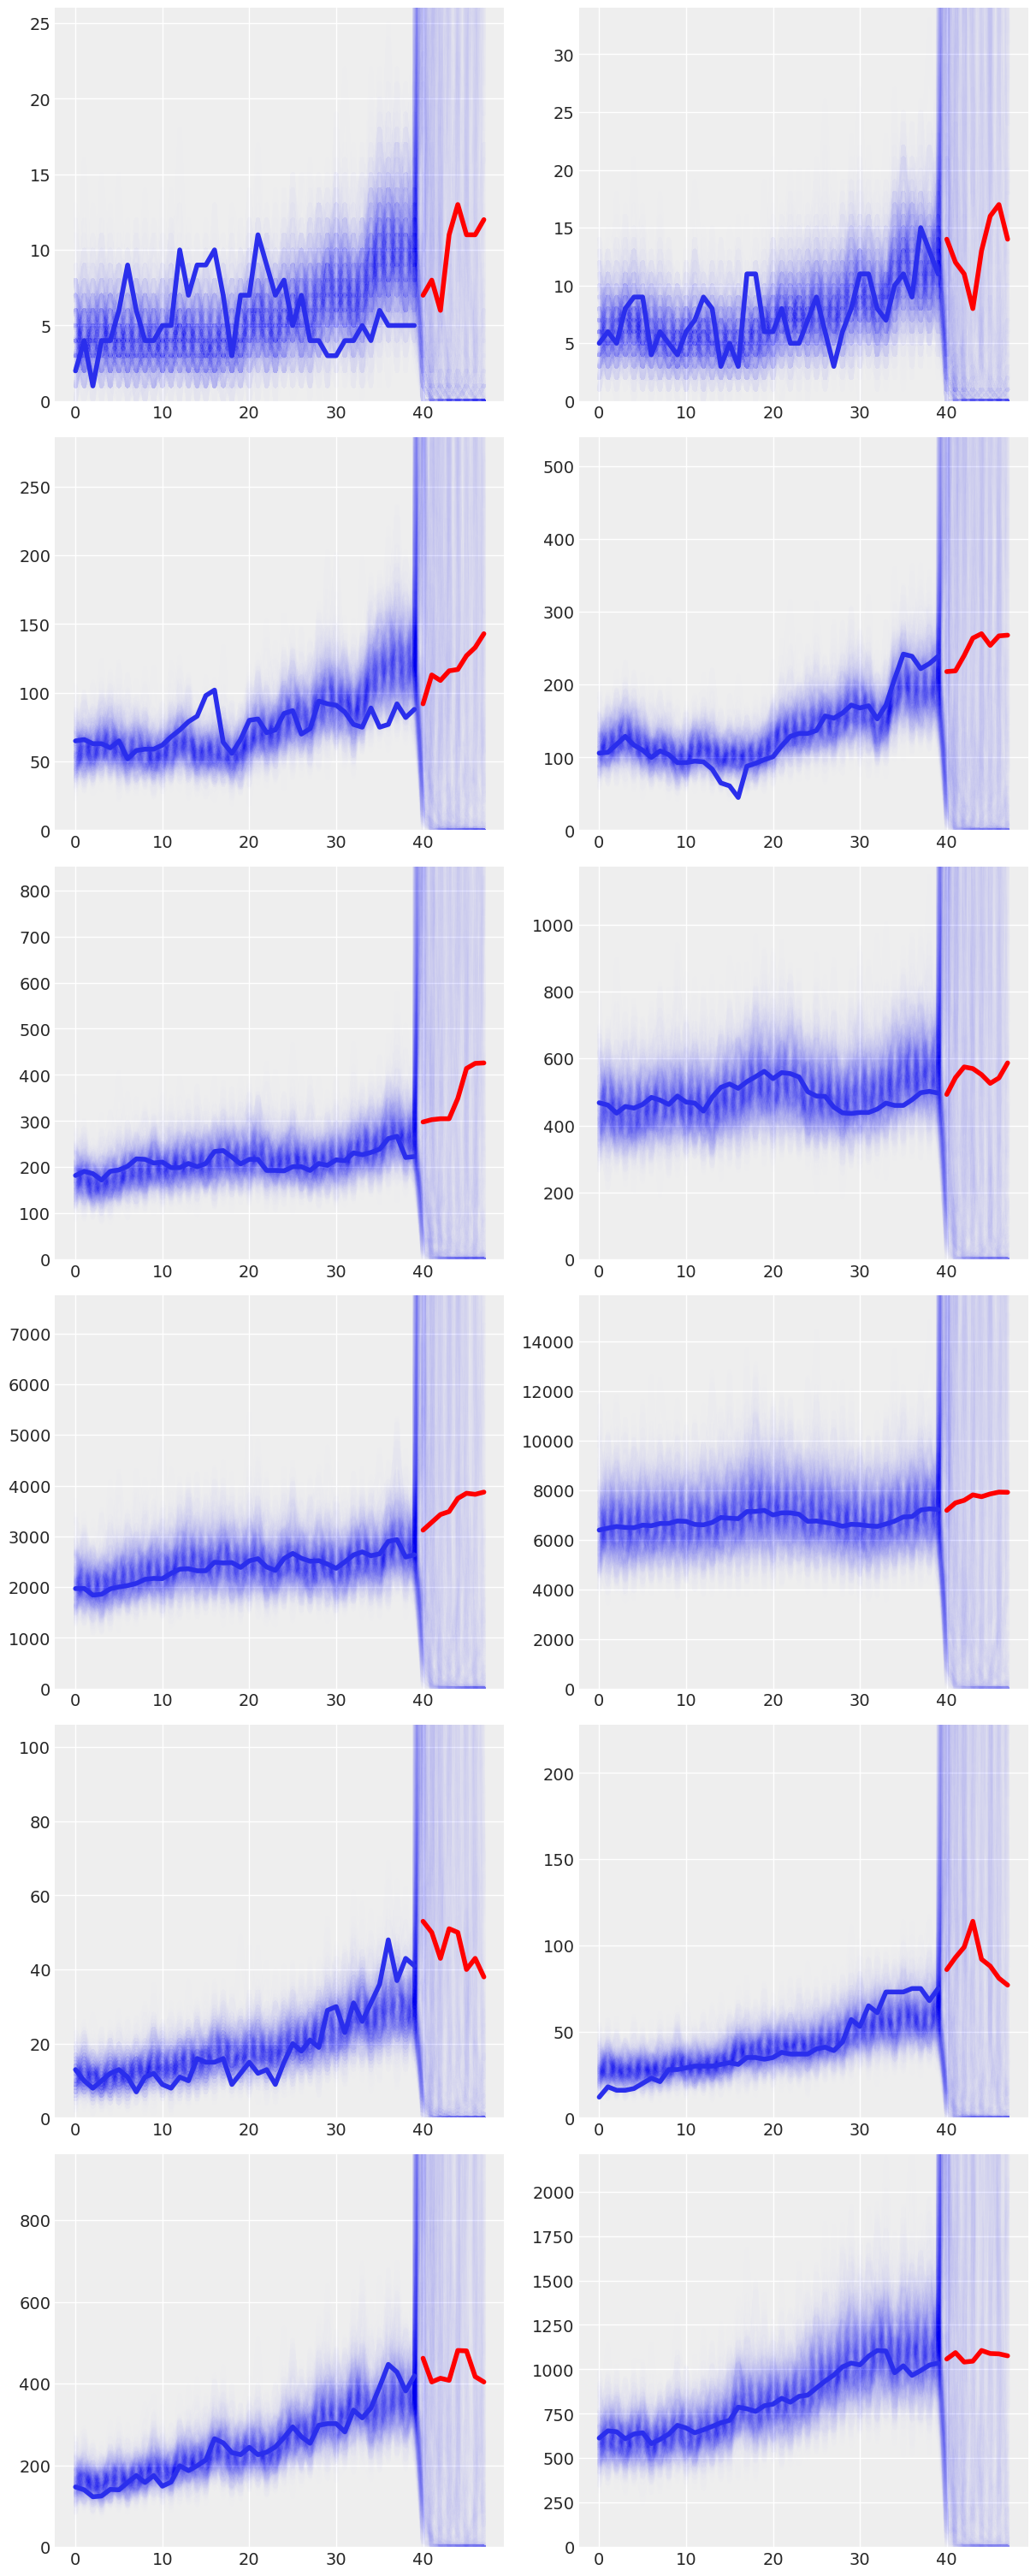

In [193]:
fig, ax = plt.subplots(6, 2, figsize=(12,30))
ax = np.ravel(ax)

for i in range(12):
    ax[i].plot(np.arange(n_new), pred_samples['y_pred_new'].T[i*n:i*n+n,:], alpha=0.003, color='blue')
    ax[i].set_ylim(0,max(y[:,i])*2)
    ax[i].plot(y[:-8,i])
    ax[i].plot(np.arange(n_new -8, n_new), y[n_new-8:,i], color='r');